In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import pickle, os, sys
from scipy import io
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.getcwd()))) # add parent folder to path
from flow import Paths, design, voi
from figures.seqplots import plot_rdm
import seq
Folder, _, _, _ = Paths.ExpData()

Background: details on how the item-position and item-item model predictions are generated from multinomial distributions see: https://gitlab.com/kristjankalm/fmri_seq_ltm/-/blob/master/notebooks_rev/encoding_models.ipynb


## Item mixture model

This model is not a sequence representation model but rather an alternative hypothesis of what is being captured by the fMRI data. This model posits that instead of sequence representations fMRI patterns reflect item representations overlaid on top of each other like a palimpsest, so that the most recent item is most promiment. For example, a sequence [1,2,3,4] could be represented as a mixture: 70% the last item (4), 20% the item before (3), and so forth. This representation is a mixture model of 4 dimensions representing the recency of the items seen. 

In [4]:
# load individual sequences
Folder, _, _, _ = Paths.ExpData()
# load individual sequences
Seq = pd.read_csv(os.path.join(Folder['SourceData'], 'sequences_individual.tsv')).values
Seq

array([[3, 1, 4, 2],
       [2, 4, 1, 3],
       [1, 2, 3, 4],
       [4, 3, 1, 2],
       [4, 2, 1, 3],
       [1, 4, 2, 3],
       [1, 3, 4, 2],
       [4, 1, 3, 2],
       [4, 2, 3, 1],
       [1, 3, 2, 4],
       [1, 2, 4, 3],
       [4, 1, 2, 3],
       [1, 4, 3, 2],
       [4, 3, 2, 1]])

We assume a recency mixture model where contributions increase with sequence position as 𝛽=[0,1/6,1/3,1/2] -- for convenience $\beta$ also sums to one.

In [5]:
Beta_recency = np.linspace(0, 1, Seq.shape[1])
Beta_recency = Beta_recency / sum(Beta_recency)
print(Beta_recency)

[0.         0.16666667 0.33333333 0.5       ]


We represent a sequence as an item mixture in our task by indicating the proportion of each four items [𝐴,𝐵,𝐶,𝐷] in the mixture, e.g.: [𝐶,𝐴,𝐷,𝐵] as [𝐴:1/6,𝐵:1/2,𝐶:0,𝐷:1/3], [𝐵,𝐷,𝐶,𝐴] as [𝐴:1/3,𝐵:0,𝐶:1/6,𝐷:1/2] and so forth.

In [12]:
# function that take the sequence (positions of items) and 
# outputs how much of each item is represented in the mixture based on \beta
def item_mixture_sim(Seq, Beta):
    I = np.zeros((Seq.shape)) # preload matrix
    # create item-based representations
    for i, s in enumerate(Seq):
        I[i] = np.flip(Beta)[s-1]
    return I

M_recency = item_mixture_sim(Seq, Beta_recency)
# display representations
M_recency

array([[0.16666667, 0.5       , 0.        , 0.33333333],
       [0.33333333, 0.        , 0.5       , 0.16666667],
       [0.5       , 0.33333333, 0.16666667, 0.        ],
       [0.        , 0.16666667, 0.5       , 0.33333333],
       [0.        , 0.33333333, 0.5       , 0.16666667],
       [0.5       , 0.        , 0.33333333, 0.16666667],
       [0.5       , 0.16666667, 0.        , 0.33333333],
       [0.        , 0.5       , 0.16666667, 0.33333333],
       [0.        , 0.33333333, 0.16666667, 0.5       ],
       [0.5       , 0.16666667, 0.33333333, 0.        ],
       [0.5       , 0.33333333, 0.        , 0.16666667],
       [0.        , 0.5       , 0.33333333, 0.16666667],
       [0.5       , 0.        , 0.16666667, 0.33333333],
       [0.        , 0.16666667, 0.33333333, 0.5       ]])

The euclidean distance between [𝐴,𝐵,𝐶,𝐷] and [𝐶,𝐴,𝐷,𝐵] as mixtures (given the recency based 𝛽=[0,1/6,1/3,1/2] as defined above) is the euclidean distance between the two four-dimensional mixture vectors:

𝑑=𝐸𝑢𝑐𝑙𝑖𝑑𝑒𝑎𝑛𝐷𝑖𝑠𝑡([1/6,1/2,0,1/3],[1/3,0,1/6,1/2])

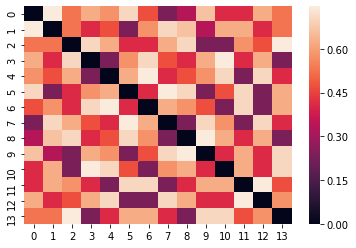

In [13]:
# compute euclidean distance between all mixture distributions
metric = 'euclidean'
RDM_recency = cdist(M_recency, M_recency, metric)
sns.heatmap(RDM_recency);

Now we use a primacy-based coefficient vector and repeat the previous steps. 

In [14]:
#Beta_primacy = np.array([0, -0.1, -0.3, -0.6])  # primacy mixture gradient
Beta_primacy = np.linspace(1, 0, Seq.shape[1])
Beta_primacy = Beta_primacy / sum(Beta_primacy)

M_primacy = item_mixture_sim(Seq, Beta_primacy)
RDM_primacy = cdist(M_primacy, M_primacy, metric)
M_primacy

array([[0.33333333, 0.        , 0.5       , 0.16666667],
       [0.16666667, 0.5       , 0.        , 0.33333333],
       [0.        , 0.16666667, 0.33333333, 0.5       ],
       [0.5       , 0.33333333, 0.        , 0.16666667],
       [0.5       , 0.16666667, 0.        , 0.33333333],
       [0.        , 0.5       , 0.16666667, 0.33333333],
       [0.        , 0.33333333, 0.5       , 0.16666667],
       [0.5       , 0.        , 0.33333333, 0.16666667],
       [0.5       , 0.16666667, 0.33333333, 0.        ],
       [0.        , 0.33333333, 0.16666667, 0.5       ],
       [0.        , 0.16666667, 0.5       , 0.33333333],
       [0.5       , 0.        , 0.16666667, 0.33333333],
       [0.        , 0.5       , 0.33333333, 0.16666667],
       [0.5       , 0.33333333, 0.16666667, 0.        ]])

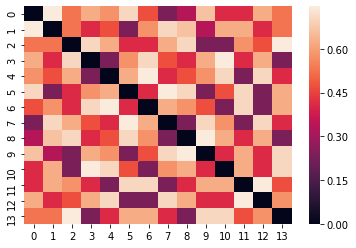

In [15]:
# plot primacy mixture RDM
sns.heatmap(RDM_primacy);

Finally, we correlate primacy and recency RDMs to each other:

In [16]:
from stats.matrix import upper_tri_vector as utv
from scipy import stats
sr = stats.spearmanr(utv(RDM_primacy), utv(RDM_recency))
sr

SpearmanrResult(correlation=0.9968745017582871, pvalue=6.559504774074267e-100)

This shows that an RDM derived with a recency-based item mixture predicts the same similarity between voxel patterns as an RDM derived with a primacy based mixture given the absolute value of the gradient slope remains the same. In other words, the sign of the slope value does not matter. 